# This notebook is for the Fair-Shapely experiment

In [1]:
%reload_ext autoreload
%autoreload 2

### 1. Import libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### 2. Import dataset

In [3]:
from src.data.unified_dataloader import load_dataset

a, processed_compas4race= load_dataset('compas4race')

In [4]:
processed_compas4race.head(3)

,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_F,c_charge_degree_M,type_of_assessment_Risk of Recidivism,score_text_High,score_text_Low,score_text_Medium,two_year_recid
0,1,-0.061334,1,-0.162011,-0.195526,-0.227625,-0.735792,1,0,1,0,1,0,1
1,1,-0.901239,1,-0.162011,-0.195526,1.703263,0.059694,1,0,1,0,1,0,1
2,1,-0.985229,1,-0.162011,1.785502,-0.227625,-0.536921,1,0,1,1,0,0,0


### 3. Split label/unlabel data, split train/test data.

In [5]:
'''COMPAS for race research'''
df = processed_compas4race.copy()
X = df.drop('two_year_recid', axis=1)
y = df['two_year_recid']

# into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=25) 
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (4305, 13)
X_test shape: (1845, 13)


### 4. Train the original model

In [6]:
model = XGBClassifier()  # 可以替换为 RandomForestClassifier() 等其他模型
model.fit(X_train,y_train)

# 预测和评估
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6742547425474255


In [7]:
X_train['race'].value_counts()

race
1    2597
0    1708
Name: count, dtype: int64

In [8]:
'''把X_train分成majority和minority两个部分'''

male_condition = X_train['race'] == 1
X_train_majority = X_train[male_condition]
y_train_majority = y_train[male_condition]

female_condition = X_train['race'] == 0
X_train_minority = X_train[female_condition]
y_train_minority = y_train[female_condition]

### 5. Evaluate the performance of original model

In [9]:
from src.attribution.oracle_metric import perturb_numpy_ver
from src.attribution import FairnessExplainer
sen_att_name = ["race"]
sen_att = [X_train.columns.get_loc(name) for name in sen_att_name]
priv_val = [1]
unpriv_dict = [list(set(X_train.values[:, sa])) for sa in sen_att]
for sa_list, pv in zip(unpriv_dict, priv_val):
    sa_list.remove(pv)
# print(f'sen_att_name:{sen_att_name}')
# print(f'sen_att:{sen_att}') # index of sensitive attribute
# print(f'priv_val:{priv_val}') # privileged value
# print(f'unpriv_dict:{unpriv_dict}') # unprivileged value(all values in the sensitive attribute, except the privileged value)



''' 
计算DR value的函数
'''
def fairness_value_function(sen_att, priv_val, unpriv_dict, X, model):
    X_disturbed = perturb_numpy_ver(
        X=X,
        sen_att=sen_att,
        priv_val=priv_val,
        unpriv_dict=unpriv_dict,
        ratio=1.0,
    )
    fx = model.predict_proba(X)[:, 1]
    fx_q = model.predict_proba(X_disturbed)[:, 1]
    return np.mean(np.abs(fx - fx_q))
original_test_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_test.values, model)
print(f'original_test_DR: {original_test_DR}')
original_train_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_train.values, model)
print(f'original_train_DR: {original_train_DR}')

c:\Users\ZhuLi\Anaconda3\envs\unlabel_fair\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


original_test_DR: 0.09175542742013931
original_train_DR: 0.09234681725502014


### 5. 把female和male匹配，（或者male和female匹配），然后进行修改，重新训练

2. 初始化FairnessExplainer
3(a). 将X_train_minority_label0与X_train_majority_label0进行匹配
3(b). 将X_train_minority_label1与X_train_majority_label1进行匹配
4(a). 使用fairshap, 从 X_train_majority_label0中找到合适的值替换X_train_minority_label0中的数据
4(b). 使用fairshap, 从 X_train_majority_label1中找到合适的值替换X_train_minority_label1中的数据
5. 计算出varphi和q
shapely value中大于0.1的值的个数有: 62
shapely value中大于0.1的值的个数有: 62


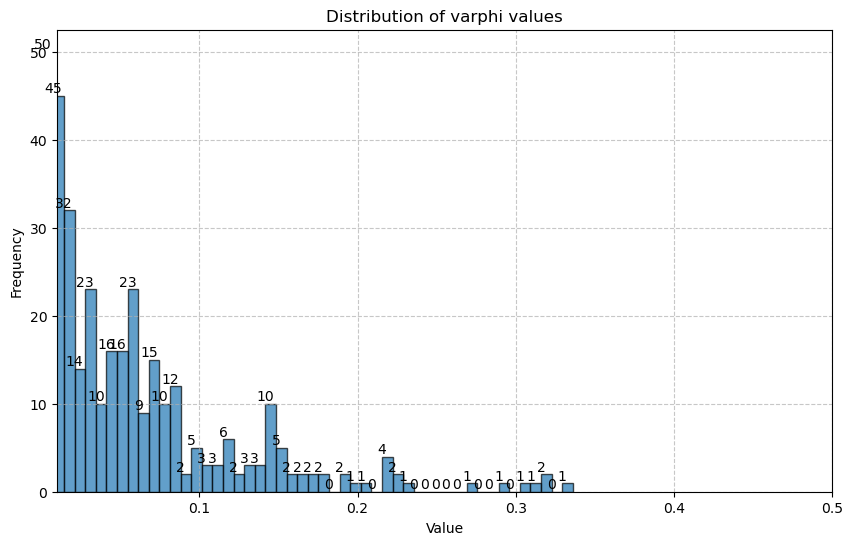

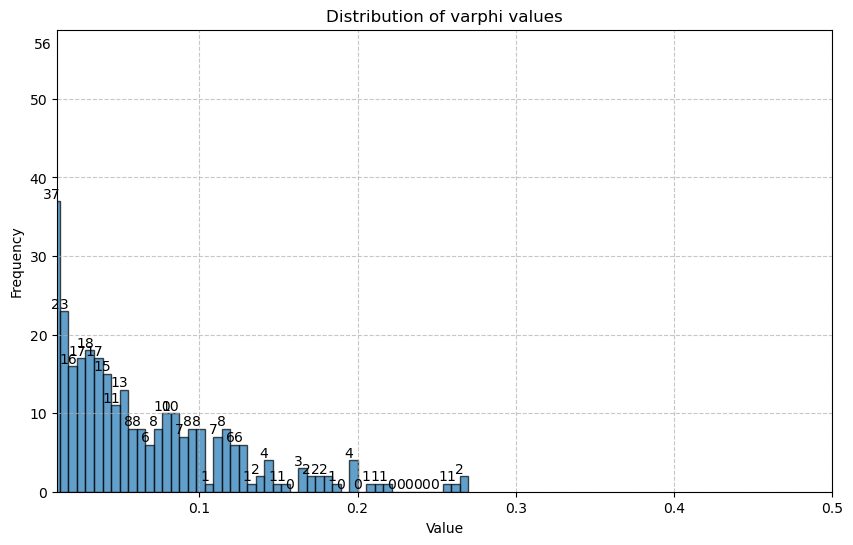

6. 开始整理并且合并新数据,共修改124个数据点, 使用new training set训练新模型
changed_value_info.shape: 123


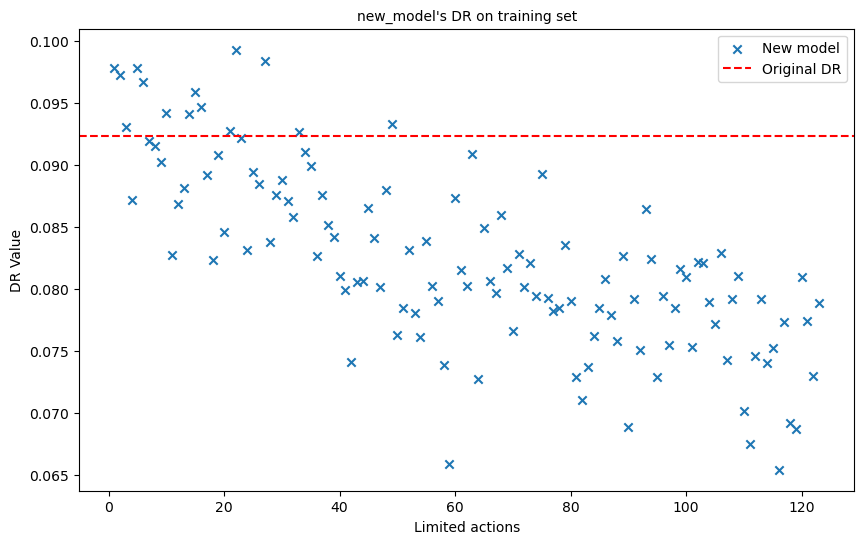

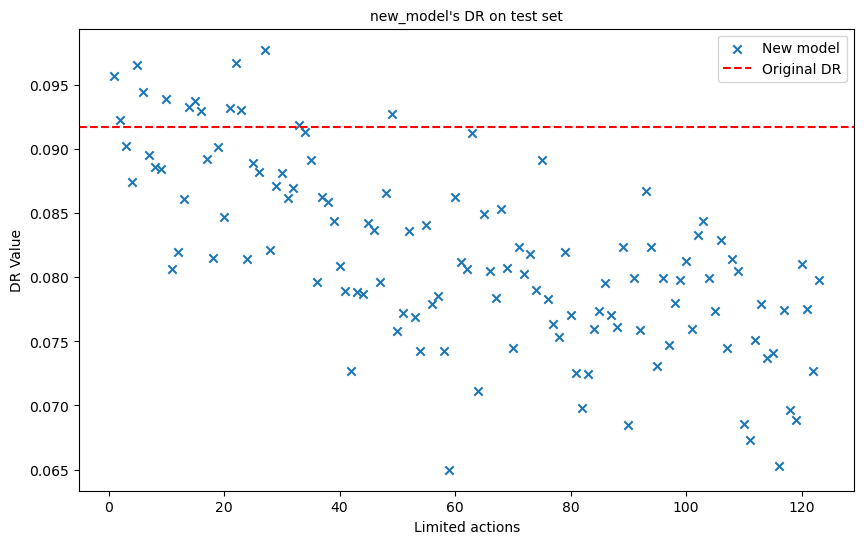

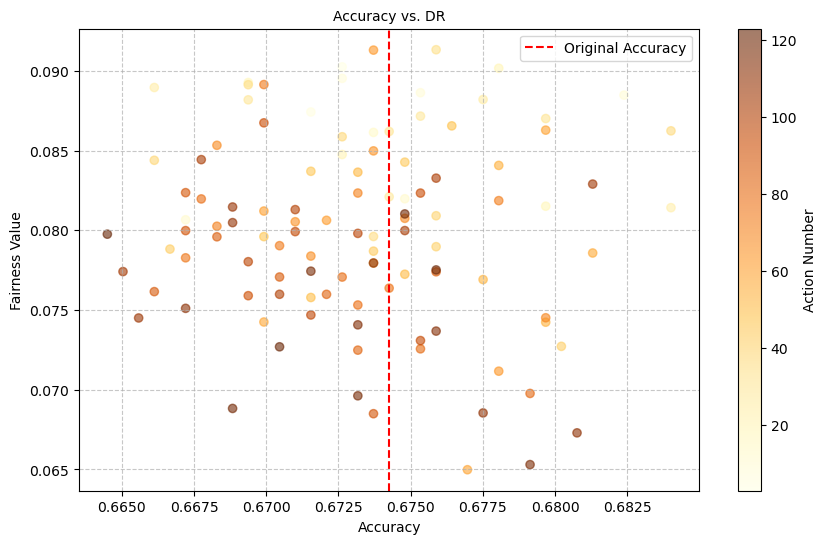

([0.095690094,
  0.0922575,
  0.09024928,
  0.087419964,
  0.09661437,
  0.09445426,
  0.08952994,
  0.08863004,
  0.088478655,
  0.09394279,
  0.08066071,
  0.08197875,
  0.086138815,
  0.09333022,
  0.09377284,
  0.092969775,
  0.0892687,
  0.08151089,
  0.09016225,
  0.08475244,
  0.093190596,
  0.096706145,
  0.09307847,
  0.08141917,
  0.088954896,
  0.088202566,
  0.0977724,
  0.08210102,
  0.0871597,
  0.08818244,
  0.08619768,
  0.087008774,
  0.09186992,
  0.091324225,
  0.08913202,
  0.07961172,
  0.08623689,
  0.08586735,
  0.084391,
  0.08091305,
  0.07897237,
  0.07272274,
  0.07882218,
  0.0786935,
  0.08427494,
  0.08370083,
  0.07960466,
  0.08654886,
  0.092717856,
  0.075786225,
  0.07724445,
  0.083643995,
  0.0769121,
  0.074236974,
  0.084069334,
  0.07794909,
  0.07857708,
  0.07424958,
  0.064985305,
  0.08628213,
  0.08120837,
  0.08062714,
  0.09130001,
  0.07116588,
  0.084980525,
  0.08053643,
  0.07838356,
  0.0853304,
  0.0807513,
  0.07451539,
  0.08233677

In [10]:
from src.experiments_approach2 import ExperimentNew
from src.experiments_approach3 import ExperimentNew2
''' 改变minority group中的部分特征值'''

experiment = ExperimentNew2(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='compas4race',
                            change_group = 'minority')
experiment.run_experiment()


2. 初始化FairnessExplainer
3(a). 将X_train_majority_label0与X_train_minority_label0进行匹配
3(b). 将X_train_majority_label1与X_train_minority_label1进行匹配
4(a). 使用fairshap, 从 X_train_minority_label0中找到合适的值替换X_train_majority_label0中的数据
4(b). 使用fairshap, 从 X_train_minority_label1中找到合适的值替换X_train_majority_label1中的数据
5. 计算出varphi和q
shapely value中大于0.1的值的个数有: 122
shapely value中大于0.1的值的个数有: 125


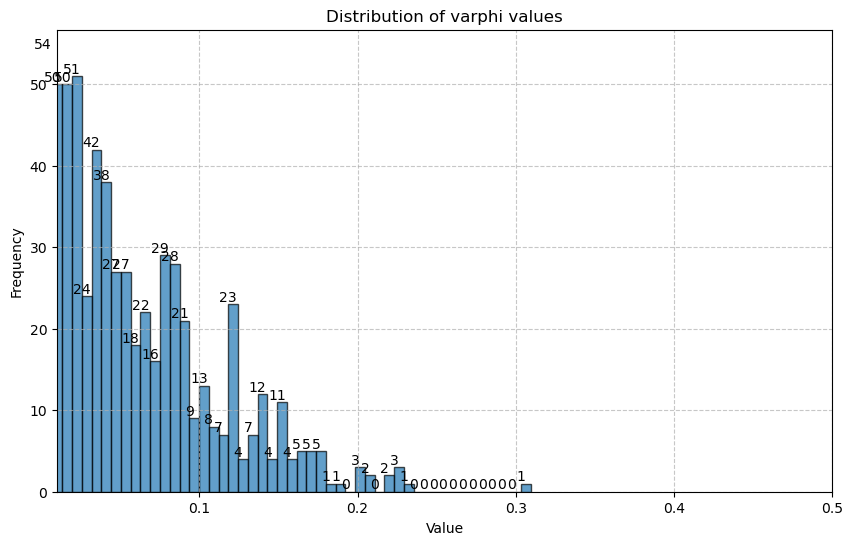

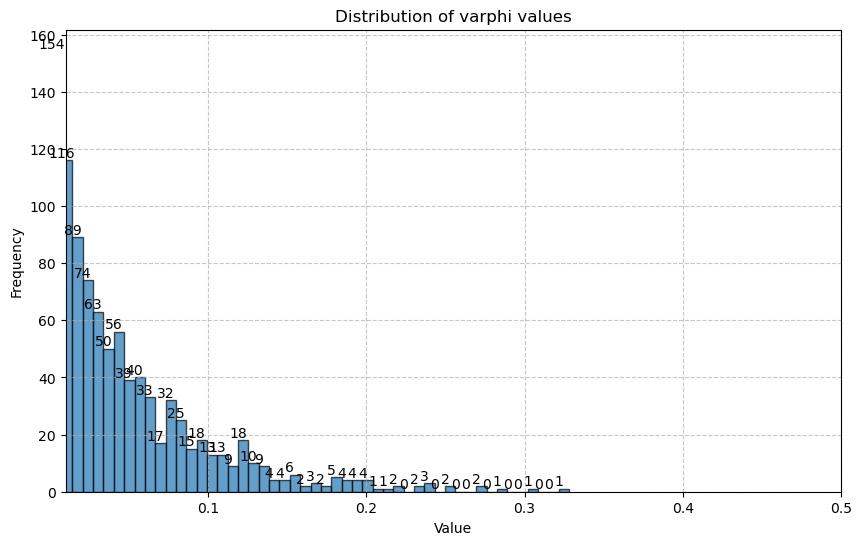

6. 开始整理并且合并新数据,共修改247个数据点, 使用new training set训练新模型
changed_value_info.shape: 246


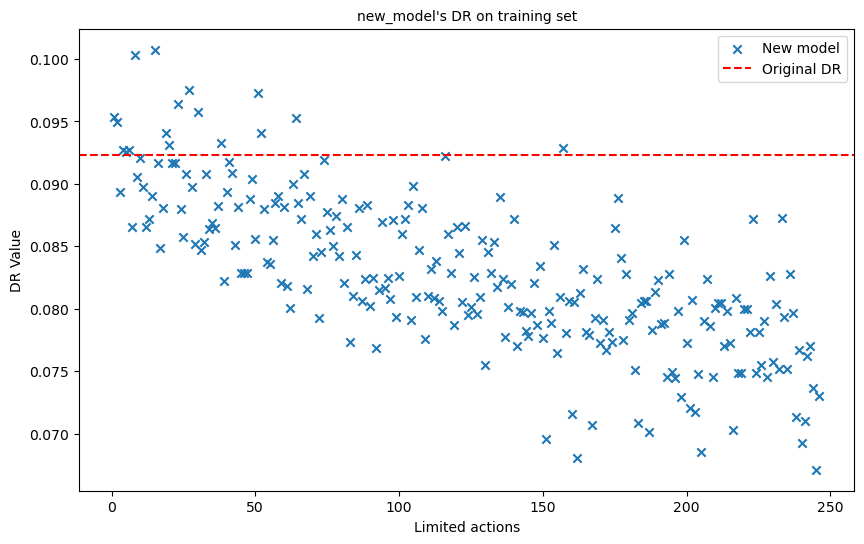

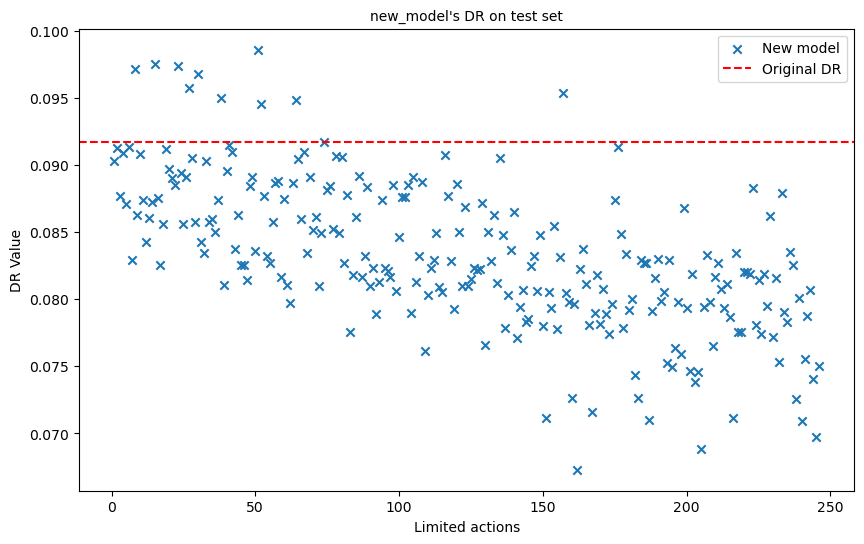

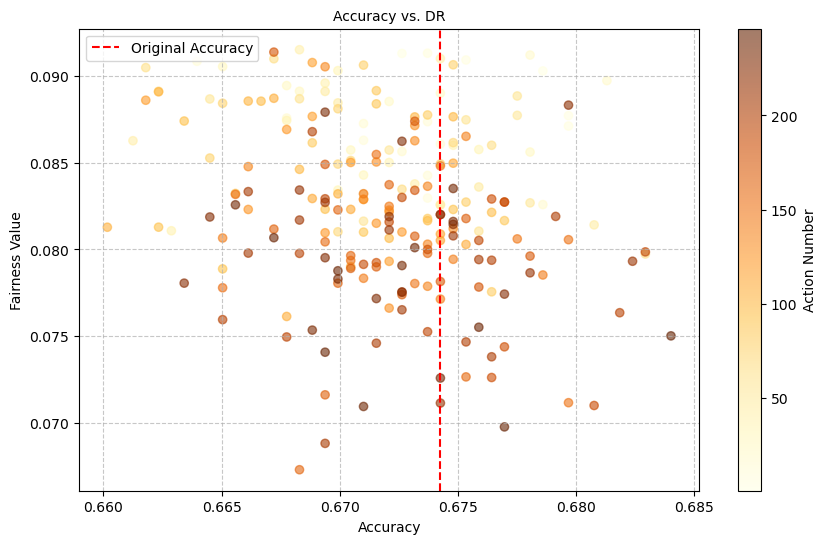

([0.090300255,
  0.091308795,
  0.08772132,
  0.09093102,
  0.08712055,
  0.091322735,
  0.08296348,
  0.09715339,
  0.08629749,
  0.09085644,
  0.0873715,
  0.084269755,
  0.086085975,
  0.08726365,
  0.09757227,
  0.08758193,
  0.08258833,
  0.0856509,
  0.09121514,
  0.08973913,
  0.08901247,
  0.08853639,
  0.0974033,
  0.08945438,
  0.08562038,
  0.08912669,
  0.09573855,
  0.09055155,
  0.085737,
  0.09683492,
  0.08429299,
  0.08342642,
  0.09031655,
  0.085765205,
  0.08601008,
  0.085017785,
  0.08744253,
  0.09504964,
  0.08107864,
  0.089597374,
  0.09152249,
  0.09101385,
  0.08378162,
  0.08627262,
  0.082594305,
  0.08256382,
  0.081417166,
  0.08845594,
  0.08911763,
  0.08360369,
  0.09861319,
  0.09456652,
  0.08773549,
  0.083209805,
  0.082688645,
  0.08573527,
  0.08868148,
  0.0888539,
  0.08163136,
  0.087478094,
  0.08105614,
  0.079737924,
  0.088693306,
  0.09489235,
  0.090490825,
  0.086010605,
  0.09100189,
  0.083472885,
  0.08912476,
  0.0851329,
  0.08616

In [11]:
''' 改变majority group中的部分特征值'''
experiment2 = ExperimentNew2(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='compas4race',
                            change_group = 'majority')
experiment2.run_experiment()